In [1]:
import numpy as np
import pandas as pd

from Datasets.utk_face import UTKFaceDataset

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

import copy

In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 300

# Number of epochs of increasing validation loss to wait before early stopping
patience = 15

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create the dataloader
dataloader = torch.utils.data.DataLoader(UTKFaceDataset(), batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("mps")

torch.Size([16, 3, 200, 200])


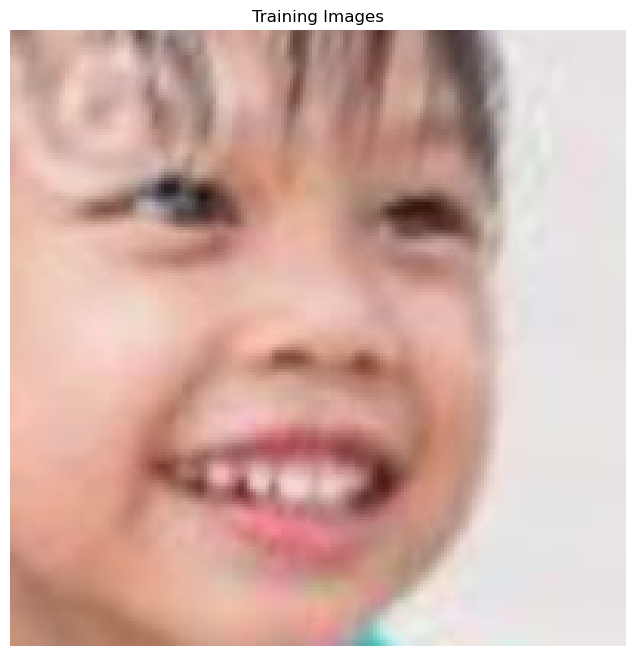

In [4]:
# Plot some training images
images, label = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(images.shape)
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()

In [5]:
from Models.vae import Autoencoder, Variational

z = 1024
layers = [
    nn.Conv2d(3, 16, 6, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(16, 8, 4, stride=2),
    nn.LeakyReLU(),
    nn.Conv2d(8, 4, 4, stride=2),
    nn.LeakyReLU(),

    nn.Flatten(),
    nn.LazyLinear(z),
    nn.ReLU(),
    Variational(z, z)
]

model = Autoencoder(layers).to(device)

/opt/homebrew/anaconda3/envs/VAE/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
best_model, best_loss = None, np.inf
epochs_waited = 0

def KL_standard_normal(mean, std):
    return torch.mean(- torch.log(std) + (torch.square(std) + torch.square(mean) - 1) / 2)

def vae_loss(images, recon, mean, std):
    return nn.MSELoss()(images, recon) + 0.1 * KL_standard_normal(mean, std)

criterion = vae_loss

optimizer = optim.Adam(model.parameters(), lr=lr)
history = []

train_batches = 100
valid_batches = 20
for epoch in range(num_epochs):
    data_iter = iter(dataloader)

    total_train_loss = 0
    for batch in range(train_batches):
        images, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        recon, mean, std = model(images)

        loss = criterion(images, recon, mean, std)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_size
    
    train_loss = total_train_loss / (batch_size * train_batches)
    print("Train loss:", train_loss)

    total_valid_loss = 0
    for batch in range(train_batches, train_batches+valid_batches):
        images, labels = next(data_iter)

        images = images.to(device)
        labels = labels.to(device)

        recon, mean, std = model(images)

        loss = criterion(images, recon, mean, std)

        total_valid_loss += loss.item() * batch_size

    valid_loss = total_valid_loss / (batch_size * valid_batches)
    print("Valid loss:", valid_loss)

    epochs_waited += 1
    if (valid_loss < best_loss):
        best_loss = valid_loss
        best_model = Autoencoder(layers)
        best_model.load_state_dict(model.state_dict())
        epochs_waited = 0

    if (epochs_waited > patience):
        break

    history.append((train_loss, valid_loss))

model = best_model
    

Train loss: 0.14454597532749175
Valid loss: 0.06683001518249512
Train loss: 0.05867212157696486
Valid loss: 0.05295432638376951
Train loss: 0.05574585687369108
Valid loss: 0.05722733810544014
Train loss: 0.05400963947176933
Valid loss: 0.05424755439162254
Train loss: 0.054989817962050436
Valid loss: 0.06000848300755024
Train loss: 0.05193098857998848
Valid loss: 0.05126770827919245
Train loss: 0.05137038126587868
Valid loss: 0.04784379079937935
Train loss: 0.04801573444157839
Valid loss: 0.04708091355860233
Train loss: 0.046323338039219376
Valid loss: 0.04883425123989582
Train loss: 0.04612962678074837
Valid loss: 0.04546686038374901
Train loss: 0.04527508843690157
Valid loss: 0.04629814475774765
Train loss: 0.04653732851147652
Valid loss: 0.044650088623166086
Train loss: 0.0430110377818346
Valid loss: 0.04423021357506514
Train loss: 0.04255220593884587
Valid loss: 0.04198595080524683
Train loss: 0.04116186514496803
Valid loss: 0.03779550129547715
Train loss: 0.041300686635077
Valid lo

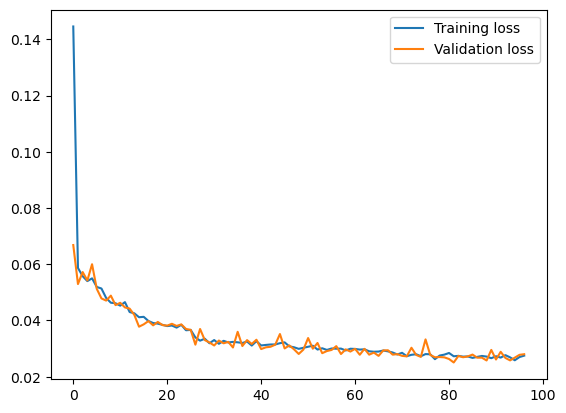

In [7]:
plt.plot(history)
plt.legend(["Training loss", "Validation loss"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


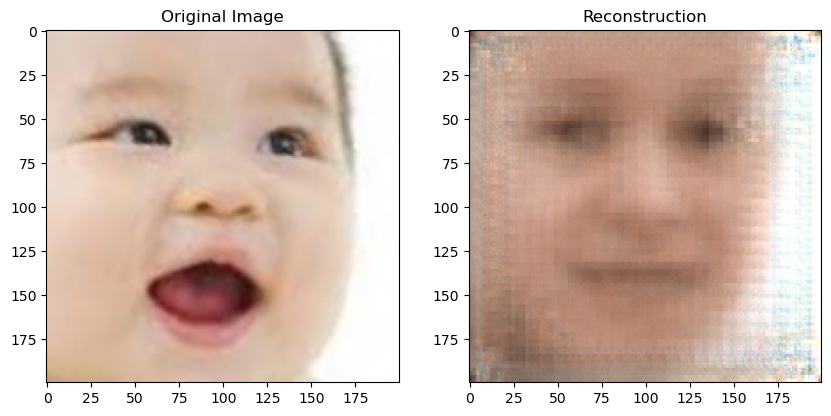

In [11]:
# Plot some training images
images, label = next(data_iter)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(images[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))

with torch.no_grad():
    recon, mean, std = model(images.to(device))

plt.subplot(1,2,2)
plt.title("Reconstruction")
plt.imshow(np.transpose(vutils.make_grid(recon[0].to(device), padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()